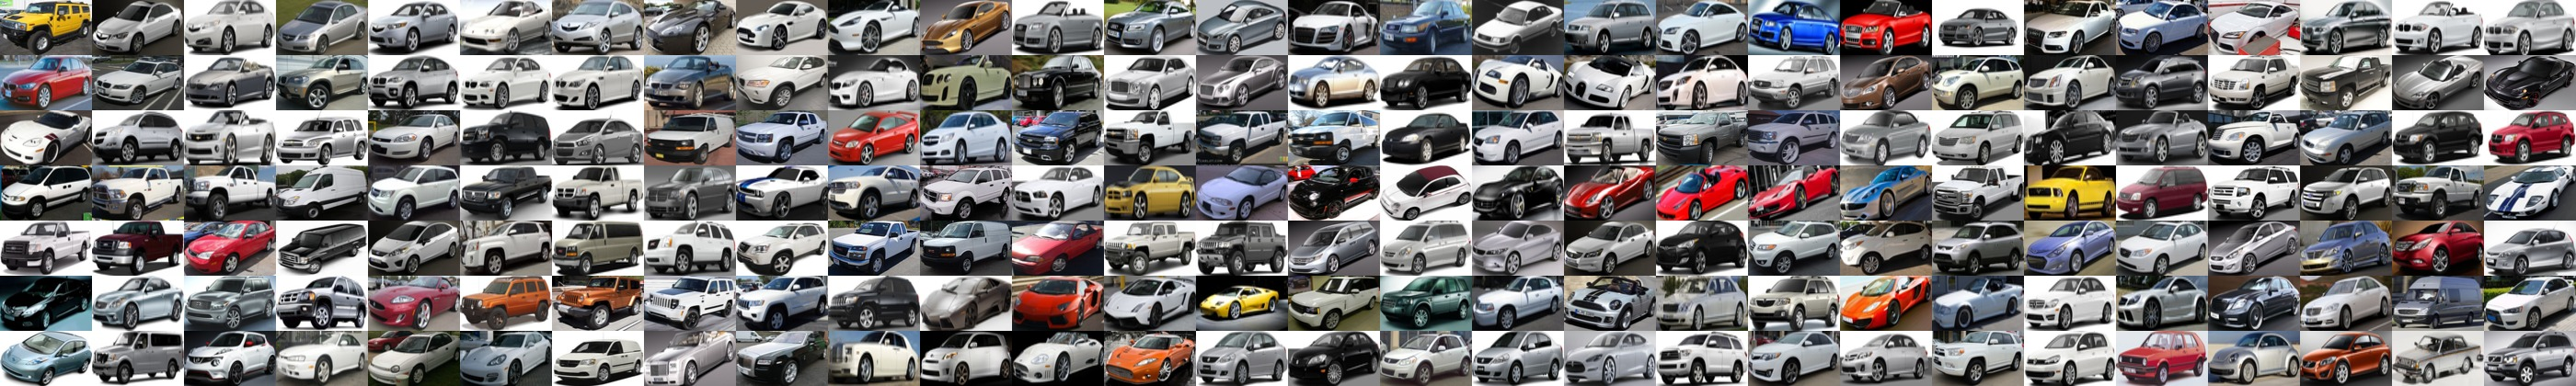

# **Final year graduation thesis**

**Topic:** Design and implementation of fine grained car image classification system

* **Supervisor:** `Prof. Wen Quan`
*   **Name:**  `Dejene Biniyam Gashaw`
*   **ID**    `2017080601042`



### Making a car classifier using Pytorch

* In this notebook I'm making a car classifier using the Stanford car dataset, which contains 196 classes.
I'll be using a pre-trained models with transfer learning to train the model. All layers will be fine tuned and the last fully connected layer will be replaced entirely.

* The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

# **Steps**
Step 0: Import Useful library

Step 1: Load the dataset

Step 2: Transform the Dataset

Step 3: Create Model

Step 4: Train and Save the Model

Step 5: Show the results

# Step 0: Import Useful library

In [1]:
from scipy.io import loadmat
from scipy.special import softmax

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F

import time
import os
import copy


import cv2
from PIL import Image
import albumentations 
from albumentations import pytorch as AT
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

cuda:0
Tesla P100-PCIE-16GB


# Step 1: Load the dataset

In [2]:
dataset_dir = "../input/stanford-car-dataset-by-classes-folder/car_data/car_data/"

# Step 2: Transform the Dataset

In [3]:
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

batch_size = 32
num_workers = 4

train_set = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers = num_workers)

test_set = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers = num_workers)
dataset_sizes = {'train': len(train_set), 'val':len(test_set)}

# Step 3: Create Model

In [4]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [5]:
def train_model(model, criterion, optimizer, scheduler, model_fname, num_epochs=25):
    time_start = time.time()

    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_acc = 0.0

    loss_list_val = []
    loss_list_train = []
    acc_list_val = []
    acc_list_train = []

    for epoch in range(num_epochs):

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('=' * 85)

        for phase in ['train', 'val']:

            if phase == 'train':
                scheduler.step(epoch_acc)
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the dataloader

            for inputs, classes in loader:
                inputs = inputs.to(device)
                classes = classes.to(device)

                optimizer.zero_grad()

                # forward propagation
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, classes)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classes.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'val':
                loss_list_val.append(epoch_loss)
                acc_list_val.append(epoch_acc)
            else:
                loss_list_train.append(epoch_loss)
                acc_list_train.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print('{} Loss: {:.4f} Accuracy: {:.4f}'
                  .format(phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - time_start

    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    path = F"{model_fname}"
    torch.save(model.state_dict(), path)

    return loss_list_train, loss_list_val, acc_list_train, acc_list_val

# Step 4: Train and Save the Model

In [6]:
loss_list_train, loss_list_val, acc_list_train, acc_list_val = train_model(model_ft, criterion, optimizer, lrscheduler,'resnet50.pth',num_epochs=40)

Epoch 0/39
train Loss: 4.0963 Accuracy: 0.1373
val Loss: 2.7398 Accuracy: 0.2737

Epoch 1/39
train Loss: 1.8130 Accuracy: 0.5246
val Loss: 1.6221 Accuracy: 0.5488

Epoch 2/39
train Loss: 0.9766 Accuracy: 0.7359
val Loss: 1.1412 Accuracy: 0.6840

Epoch 3/39
train Loss: 0.6015 Accuracy: 0.8383
val Loss: 0.8965 Accuracy: 0.7436

Epoch 4/39
train Loss: 0.4284 Accuracy: 0.8840
val Loss: 0.6909 Accuracy: 0.8072

Epoch 5/39
train Loss: 0.3056 Accuracy: 0.9218
val Loss: 0.6006 Accuracy: 0.8324

Epoch 6/39
train Loss: 0.1336 Accuracy: 0.9729
val Loss: 0.3291 Accuracy: 0.9107

Epoch 7/39
train Loss: 0.0888 Accuracy: 0.9837
val Loss: 0.3104 Accuracy: 0.9168

Epoch 8/39
train Loss: 0.0773 Accuracy: 0.9871
val Loss: 0.3012 Accuracy: 0.9184

Epoch 9/39
train Loss: 0.0726 Accuracy: 0.9877
val Loss: 0.3003 Accuracy: 0.9195

Epoch 10/39
train Loss: 0.0640 Accuracy: 0.9883
val Loss: 0.2987 Accuracy: 0.9194

Epoch 11/39
train Loss: 0.0620 Accuracy: 0.9899
val Loss: 0.3008 Accuracy: 0.9185

Epoch 12/39
tr

# Step 5: Show the results

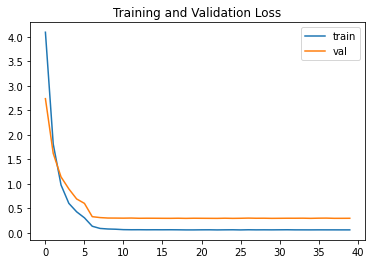

In [7]:
plt.plot(loss_list_train, label='train')
plt.plot(loss_list_val, label='val')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

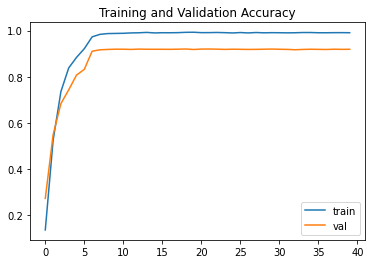

In [8]:
plt.plot(acc_list_train, label='train')
plt.plot(acc_list_val, label='val')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()